# Imports

In [23]:
from sklearn.ensemble import VotingClassifier
from joblib import load
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [24]:
def read_csv_file(file_path):
    """
    Reads a CSV file and returns its content as a pandas DataFrame.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except ValueError as e:
        print(f"Error reading CSV file: {e}")
        return None
    
    

# Chargement des données
train_data = pd.read_csv('data/train.csv')
descriptors = train_data.iloc[:, 1:200]
smiles = train_data.iloc[:, 0]  
fingerprints = train_data.iloc[:, 200:-1]
labels = train_data.iloc[:, -1]


In [ ]:

X = pd.concat([descriptors, fingerprints], axis=1)
y = labels

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Chargement des modèles pré-entraînés
model1 = load('models/logistic_regression_model.joblib')  # fingerpints
model2 = load('models/xgb_classifier_model.joblib')       # descripteurs


# Création d’un VotingClassifier en mode soft (avec predict_proba)
ensemble = VotingClassifier(
    estimators=[
        ('lr', model1),
        ('xgb', model2)
    ],
    voting='soft' 
)


ensemble.fit(X_train, y_train)

# Prédictions
y_pred = ensemble.predict(X_test)
y_proba = ensemble.predict_proba(X_test)

# Évaluation
print("F1 Score:", f1_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))


c:\Users\nonoa\.pyenv\pyenv-win\versions\3.12.8\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nonoa\.pyenv\pyenv-win\versions\3.12.8\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 Score: 0.8130595050026329
Accuracy: 0.8114710568242167
Classification Report:
               precision    recall  f1-score   support

           0      0.795     0.825     0.810       916
           1      0.828     0.798     0.813       967

    accuracy                          0.811      1883
   macro avg      0.812     0.812     0.811      1883
weighted avg      0.812     0.811     0.812      1883



In [32]:
def cohen_kappa(annotator1, annotator2):
    # Créer la matrice de confusion
    confusion_matrix = np.zeros((max(annotator1 + annotator2), max(annotator1 + annotator2)))
    for a1, a2 in zip(annotator1, annotator2):
        confusion_matrix[a1-1][a2-1] += 1

    # Calculer p_o
    po = np.trace(confusion_matrix) / len(annotator1)

    # Calculer p_e
    row_sums = np.sum(confusion_matrix, axis=1)
    col_sums = np.sum(confusion_matrix, axis=0)
    pe = np.sum(row_sums * col_sums) / (len(annotator1) ** 2)

    # Calculer Kappa
    kappa = (po - pe) / (1 - pe)

    return kappa



kappa_score = cohen_kappa(y_test.values, y_pred)
print(f"Cohen's Kappa Score: {kappa_score}")

Cohen's Kappa Score: 0.6230451315012613


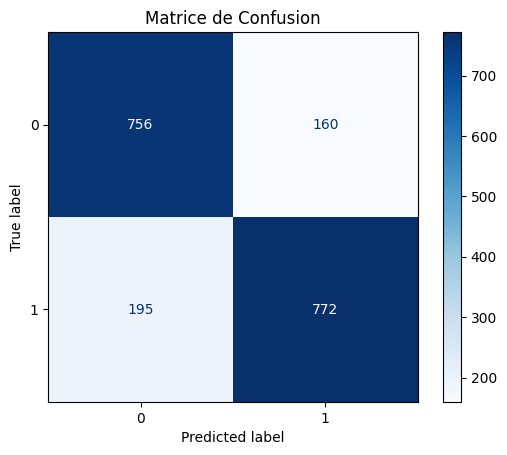

In [33]:
# Calculer et afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ensemble.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.show()

In [36]:
def save_predictions(smiles_list, y_pred, name):
    """
    Save predictions to a CSV file.
    
    Parameters:
    smiles_list (list): List of SMILES strings.
    y_pred (list): List of predicted labels.
    output_path (str): Path to save the predictions CSV file.
    """
    if len(smiles_list) != len(y_pred):
        raise ValueError("Length of SMILES list and predictions must match.")
    
    output_path='predictions/' + name + '.csv'
    
    # Create a DataFrame and save it to CSV 
    df = pd.DataFrame({
        "smiles": smiles_list,
        name : y_pred
    })
    df.to_csv(output_path, index=False)
    print(f"✅ Prédictions enregistrées dans : {output_path}")

def save_probas(smiles_list, y_proba, name):
    """
    Save predictions to a CSV file.
    
    Parameters:
    smiles_list (list): List of SMILES strings.
    y_pred (list): List of predicted labels.
    output_path (str): Path to save the predictions CSV file.
    """
    if len(smiles_list) != len(y_proba):
        raise ValueError("Length of SMILES list and predictions must match.")
    
    output_path='predictions/' + name + '.csv'

    # Create a DataFrame and save it to CSV 
    df = pd.DataFrame({
        "smiles": smiles_list,
        name : y_proba
    })
    df.to_csv(output_path, index=False)
    print(f"✅ Prédictions enregistrées dans : {output_path}")


_, smiles_test = train_test_split(smiles, test_size=0.2, random_state=42, stratify=y)




save_predictions(smiles_test, y_pred, 'ensemble_pred')
y_proba = ensemble.predict_proba(X_test)
save_probas(smiles_test, y_proba[:, 1], 'ensemble_proba')

✅ Prédictions enregistrées dans : predictions/ensemble_pred.csv
✅ Prédictions enregistrées dans : predictions/ensemble_proba.csv


In [28]:
# Entrainer le classificateur XGBoost avec la validation croisée
ensemble.fit(X.values, y.values)

# Définir la validation croisée stratifiée
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Effectuer la validation croisée stratifiée
scores = cross_val_score(ensemble, X.values, y.values, cv=stratified_kfold)
# print(f"Cross-Validation Scores: {scores}")
print(f"Mean Cross-Validation Score: {np.mean(scores)}")
print(f"Standard Deviation of Cross-Validation Scores: {np.std(scores)}")

c:\Users\nonoa\.pyenv\pyenv-win\versions\3.12.8\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nonoa\.pyenv\pyenv-win\versions\3.12.8\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\nonoa\.pyenv\pyenv-win\versions\3.12.8\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was depr

Mean Cross-Validation Score: 0.8127488938677063
Standard Deviation of Cross-Validation Scores: 0.01510091933756997
